# Fetch Rewards Coding Exercise  
#### Position: Data Products Team Lead 
#### Applicant: Nicholas Dysle

### Settings/Libraries
Read in settings and libraries.

In [215]:
# Import Libraries
import json
import gzip
import sqlite3
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import tarfile
from pandas import json_normalize
import numpy as np
import seaborn as sns
from scipy import stats

In [216]:
# Settings
print(f"Working Directory:{os.getcwd()}")

# Set data location: 
data_loc = '/Users/nicholasdysle/Documents/GitHub/FetchRewards/data'

Working Directory:/Users/nicholasdysle/Documents/GitHub/FetchRewards/notebooks


### Exploring the data

#### Loading JSONs to explore their structure

##### Receipts JSON

In [217]:
# Import the data
receipts_data = []
receipts_file = "../data/receipts.json.gz"

with gzip.open(receipts_file, 'rt', encoding='utf-8') as f:
    receipts_data = [json.loads(line) for line in f]
    
first_receipt = receipts_data[0]

# Check sample of data
first_receipt

{'_id': {'$oid': '5ff1e1eb0a720f0523000575'},
 'bonusPointsEarned': 500,
 'bonusPointsEarnedReason': 'Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)',
 'createDate': {'$date': 1609687531000},
 'dateScanned': {'$date': 1609687531000},
 'finishedDate': {'$date': 1609687531000},
 'modifyDate': {'$date': 1609687536000},
 'pointsAwardedDate': {'$date': 1609687531000},
 'pointsEarned': '500.0',
 'purchaseDate': {'$date': 1609632000000},
 'purchasedItemCount': 5,
 'rewardsReceiptItemList': [{'barcode': '4011',
   'description': 'ITEM NOT FOUND',
   'finalPrice': '26.00',
   'itemPrice': '26.00',
   'needsFetchReview': False,
   'partnerItemId': '1',
   'preventTargetGapPoints': True,
   'quantityPurchased': 5,
   'userFlaggedBarcode': '4011',
   'userFlaggedNewItem': True,
   'userFlaggedPrice': '26.00',
   'userFlaggedQuantity': 5}],
 'rewardsReceiptStatus': 'FINISHED',
 'totalSpent': '26.00',
 'userId': '5ff1e1eacfcf6c399c274ae6'}

In [218]:
# Check the keys and rewardsReceiptItemList
print(f"Keys: {list(first_receipt.keys())}")
print(f"rewardsReceiptItemList type: {type(first_receipt.get('rewardsReceiptItemList'))}")

Keys: ['_id', 'bonusPointsEarned', 'bonusPointsEarnedReason', 'createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'pointsEarned', 'purchaseDate', 'purchasedItemCount', 'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 'userId']
rewardsReceiptItemList type: <class 'list'>


In [219]:
# Take a sample of the nested list
first_receipt['rewardsReceiptItemList'][0]

{'barcode': '4011',
 'description': 'ITEM NOT FOUND',
 'finalPrice': '26.00',
 'itemPrice': '26.00',
 'needsFetchReview': False,
 'partnerItemId': '1',
 'preventTargetGapPoints': True,
 'quantityPurchased': 5,
 'userFlaggedBarcode': '4011',
 'userFlaggedNewItem': True,
 'userFlaggedPrice': '26.00',
 'userFlaggedQuantity': 5}

In [220]:
# Check data structure
receipts_df = pd.DataFrame(receipts_data)
print(f"Receipts shape: {receipts_df.shape}")
print(f"Receipts columns: {list(receipts_df.columns)}")

Receipts shape: (1119, 15)
Receipts columns: ['_id', 'bonusPointsEarned', 'bonusPointsEarnedReason', 'createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'pointsEarned', 'purchaseDate', 'purchasedItemCount', 'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 'userId']


In [221]:
# Check for nested data issues
# Count total items across all receipts to see if they match the receipts rows
total_items = 0
for receipt in receipts_data:
    if receipt.get('rewardsReceiptItemList'):
        total_items += len(receipt['rewardsReceiptItemList'])
else:
    print(f"{total_items}")
    
# The numbers do not match (1119 vs 6941) so we will need to amend the data 
# because there are multiple items in each receipt

6941


In [222]:
# Receipts data
receipts_df = pd.json_normalize(receipts_data)
receipts_df

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id.$oid,createDate.$date,dateScanned.$date,finishedDate.$date,modifyDate.$date,pointsAwardedDate.$date,purchaseDate.$date
0,500.0,"Receipt number 2 completed, bonus point schedu...",500.0,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6,5ff1e1eb0a720f0523000575,1609687531000,1609687531000,1.609688e+12,1609687536000,1.609688e+12,1.609632e+12
1,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,1609687483000,1609687483000,1.609687e+12,1609687488000,1.609687e+12,1.609601e+12
2,5.0,All-receipts receipt bonus,5,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,1609687537000,1609687537000,NaN,1609687542000,NaN,1.609632e+12
3,5.0,All-receipts receipt bonus,5.0,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6,5ff1e1ee0a7214ada100056f,1609687534000,1609687534000,1.609688e+12,1609687539000,1.609688e+12,1.609632e+12
4,5.0,All-receipts receipt bonus,5.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052,5ff1e1d20a7214ada1000561,1609687506000,1609687506000,1.609688e+12,1609687511000,1.609688e+12,1.609601e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,5fc961c3b8cfca11a077dd33,603cc0630a720fde100003e6,1614594147000,1614594147000,NaN,1614594148000,NaN,1.597622e+12
1115,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33,603d0b710a720fde1000042a,1614613361873,1614613361873,NaN,1614613361873,NaN,NaN
1116,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33,603cf5290a720fde10000413,1614607657664,1614607657664,NaN,1614607657664,NaN,NaN
1117,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,5fc961c3b8cfca11a077dd33,603ce7100a7217c72c000405,1614604048000,1614604048000,NaN,1614604049000,NaN,1.597622e+12


In [223]:
# Check column type
for col in receipts_df.columns:
    print(f"{col}: {receipts_df[col].dtype}")

bonusPointsEarned: float64
bonusPointsEarnedReason: object
pointsEarned: object
purchasedItemCount: float64
rewardsReceiptItemList: object
rewardsReceiptStatus: object
totalSpent: object
userId: object
_id.$oid: object
createDate.$date: int64
dateScanned.$date: int64
finishedDate.$date: float64
modifyDate.$date: int64
pointsAwardedDate.$date: float64
purchaseDate.$date: float64


In [224]:
# Reformatting select columns
receipts_df['_id'] = receipts_df['_id.$oid']
receipts_df['createDate'] = pd.to_datetime(receipts_df['createDate.$date'], unit='ms')
receipts_df['dateScanned'] = pd.to_datetime(receipts_df['dateScanned.$date'], unit='ms')
receipts_df['finishedDate'] = pd.to_datetime(receipts_df['finishedDate.$date'], unit='ms')
receipts_df['modifyDate'] = pd.to_datetime(receipts_df['modifyDate.$date'], unit='ms')
receipts_df['pointsAwardedDate'] = pd.to_datetime(receipts_df['pointsAwardedDate.$date'], unit='ms')
receipts_df['purchaseDate'] = pd.to_datetime(receipts_df['purchaseDate.$date'], unit='ms')


# Retaining only the necessary columns (purposing leaving out 'rewardsReceiptItemList')
receipts_df = receipts_df[['_id', 'bonusPointsEarned', 'bonusPointsEarnedReason', 'createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'pointsEarned', 'purchaseDate', 'purchasedItemCount', 'rewardsReceiptStatus', 'totalSpent', 'userId']]

In [225]:
# Checking the final output
receipts_df

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31.000,2021-01-03 15:25:31.000,2021-01-03 15:25:31,2021-01-03 15:25:36.000,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43.000,2021-01-03 15:24:43.000,2021-01-03 15:24:43,2021-01-03 15:24:48.000,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37.000,2021-01-03 15:25:37.000,NaT,2021-01-03 15:25:42.000,NaT,5,2021-01-03 00:00:00,1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34.000,2021-01-03 15:25:34.000,2021-01-03 15:25:34,2021-01-03 15:25:39.000,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06.000,2021-01-03 15:25:06.000,2021-01-03 15:25:11,2021-01-03 15:25:11.000,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,603cc0630a720fde100003e6,25.0,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 10:22:27.000,2021-03-01 10:22:27.000,NaT,2021-03-01 10:22:28.000,NaT,25.0,2020-08-17 00:00:00,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1115,603d0b710a720fde1000042a,NaN,NaN,2021-03-01 15:42:41.873,2021-03-01 15:42:41.873,NaT,2021-03-01 15:42:41.873,NaT,NaN,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1116,603cf5290a720fde10000413,NaN,NaN,2021-03-01 14:07:37.664,2021-03-01 14:07:37.664,NaT,2021-03-01 14:07:37.664,NaT,NaN,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1117,603ce7100a7217c72c000405,25.0,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 13:07:28.000,2021-03-01 13:07:28.000,NaT,2021-03-01 13:07:29.000,NaT,25.0,2020-08-17 00:00:00,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33


In [226]:
# Create receipt_items table (extract items from nested list)
receipt_items = []
for receipt in receipts_data:
    if receipt.get('rewardsReceiptItemList'):
        for item in receipt['rewardsReceiptItemList']:
            # Add receipt ID to each item
            item['receiptId'] = receipt['_id']
            receipt_items.append(item)

            
receipt_items_df = json_normalize(receipt_items)

In [227]:
# Check column type
for col in receipt_items_df.columns:
    print(f"{col}: {receipt_items_df[col].dtype}")

barcode: object
description: object
finalPrice: object
itemPrice: object
needsFetchReview: object
partnerItemId: object
preventTargetGapPoints: object
quantityPurchased: float64
userFlaggedBarcode: object
userFlaggedNewItem: object
userFlaggedPrice: object
userFlaggedQuantity: float64
receiptId.$oid: object
needsFetchReviewReason: object
pointsNotAwardedReason: object
pointsPayerId: object
rewardsGroup: object
rewardsProductPartnerId: object
userFlaggedDescription: object
originalMetaBriteBarcode: object
originalMetaBriteDescription: object
brandCode: object
competitorRewardsGroup: object
discountedItemPrice: object
originalReceiptItemText: object
itemNumber: object
originalMetaBriteQuantityPurchased: float64
pointsEarned: object
targetPrice: object
competitiveProduct: object
originalFinalPrice: object
originalMetaBriteItemPrice: object
deleted: object
priceAfterCoupon: object
metabriteCampaignId: object


In [228]:
# Clean up the name of ReceiptId
receipt_items_df = receipt_items_df.rename(columns={'receiptId.$oid': 'receiptId'})

In [229]:
# Running into issues with pushing this dataset to SQL so I am changing the structure of data types
for col in receipt_items_df.columns:
    if receipt_items_df[col].dtype == 'object':
        receipt_items_df[col] = receipt_items_df[col].astype(str)

##### Brands JSON

In [230]:
# Import the data
brands_data = []
brands_file = "../data/brands.json.gz"

with gzip.open(brands_file, 'rt', encoding='utf-8') as f:
    brands_data = [json.loads(line) for line in f]
    
first_brands = brands_data[0]

# Check sample of data
first_brands

{'_id': {'$oid': '601ac115be37ce2ead437551'},
 'barcode': '511111019862',
 'category': 'Baking',
 'categoryCode': 'BAKING',
 'cpg': {'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'},
 'name': 'test brand @1612366101024',
 'topBrand': False}

In [231]:
# Check the keys and cpg
print(f"Keys: {list(first_brands.keys())}")
print(f"cpg type: {type(first_brands.get('cpg'))}")

Keys: ['_id', 'barcode', 'category', 'categoryCode', 'cpg', 'name', 'topBrand']
cpg type: <class 'dict'>


In [232]:
# Check data structure
brands_df = pd.DataFrame(brands_data)
print(f"Brands shape: {brands_df.shape}")
print(f"Brands columns: {list(brands_df.columns)}")

Brands shape: (1167, 8)
Brands columns: ['_id', 'barcode', 'category', 'categoryCode', 'cpg', 'name', 'topBrand', 'brandCode']


In [233]:
brands_df = json_normalize(brands_data)
brands_df

,barcode,category,categoryCode,name,topBrand,_id.$oid,cpg.$id.$oid,cpg.$ref,brandCode
0,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs,NaN
1,511111519928,Beverages,BEVERAGES,Starbucks,False,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS
2,511111819905,Baking,BAKING,test brand @1612366146176,False,601ac142be37ce2ead43755d,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146176
3,511111519874,Baking,BAKING,test brand @1612366146051,False,601ac142be37ce2ead43755a,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146051
4,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,601ac142be37ce2ead43755e,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...
1162,511111116752,Baking,BAKING,test brand @1601644365844,NaN,5f77274dbe37ce6b592e90c0,5f77274dbe37ce6b592e90bf,Cogs,NaN
1163,511111706328,Breakfast & Cereal,NaN,Dippin Dots® Cereal,NaN,5dc1fca91dda2c0ad7da64ae,53e10d6368abd3c7065097cc,Cogs,DIPPIN DOTS CEREAL
1164,511111416173,Candy & Sweets,CANDY_AND_SWEETS,test brand @1598639215217,NaN,5f494c6e04db711dd8fe87e7,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1598639215217
1165,511111400608,Grocery,NaN,LIPTON TEA Leaves,False,5a021611e4b00efe02b02a57,5332f5f6e4b03c9a25efd0b4,Cogs,LIPTON TEA Leaves


In [234]:
# Check column type
for col in brands_df.columns:
    print(f"{col}: {brands_df[col].dtype}")

barcode: object
category: object
categoryCode: object
name: object
topBrand: object
_id.$oid: object
cpg.$id.$oid: object
cpg.$ref: object
brandCode: object


In [235]:
# Reformatting select columns
brands_df['cpg_ref'] = brands_df['cpg.$ref']
brands_df['cpg_id'] = brands_df['cpg.$id.$oid']
brands_df['_id'] = brands_df['_id.$oid']

# Retaining only the necessary columns
brands_df = brands_df[['_id', 'barcode', 'category', 'categoryCode', 'cpg_id','cpg_ref', 'name', 'topBrand', 'brandCode']]

In [236]:
# Checking the final output
brands_df

,_id,barcode,category,categoryCode,cpg_id,cpg_ref,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,Cogs,test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1612366146827,False,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...
1162,5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,5f77274dbe37ce6b592e90bf,Cogs,test brand @1601644365844,NaN,NaN
1163,5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,53e10d6368abd3c7065097cc,Cogs,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,5332f5f6e4b03c9a25efd0b4,Cogs,LIPTON TEA Leaves,False,LIPTON TEA Leaves


##### Users JSON

In [237]:
# An error was received when trying to load the users.json.gz, so I checked the file type to gain more information
!file /Users/nicholasdysle/Documents/GitHub/FetchRewards/data/users.json.gz

/Users/nicholasdysle/Documents/GitHub/FetchRewards/data/users.json.gz: gzip compressed data, was "users.json.tar", last modified: Mon Feb 26 20:14:45 2024, max speed, from Unix, original size modulo 2^32 90112


In [238]:
# Import the data
users_data = []
users_file = "../data/users.json.gz"

with tarfile.open(users_file, 'r:gz') as tar:
    m = tar.getmembers()[0]
    f = tar.extractfile(m)
    users_data = [json.loads(line) for line in f]
    
first_users = users_data[0]

# Check sample of data
first_users

{'_id': {'$oid': '5ff1e194b6a9d73a3a9f1052'},
 'active': True,
 'createdDate': {'$date': 1609687444800},
 'lastLogin': {'$date': 1609687537858},
 'role': 'consumer',
 'signUpSource': 'Email',
 'state': 'WI'}

In [239]:
# Check the keys and cpg
print(f"Keys: {list(first_users.keys())}")

Keys: ['_id', 'active', 'createdDate', 'lastLogin', 'role', 'signUpSource', 'state']


In [240]:
# Check data structure
users_df = pd.DataFrame(users_data)
print(f"Users shape: {users_df.shape}")
print(f"Users columns: {list(users_df.columns)}")

Users shape: (495, 7)
Users columns: ['_id', 'active', 'createdDate', 'lastLogin', 'role', 'signUpSource', 'state']


In [241]:
# Normalizing the JSON data
users_df = json_normalize(users_data)
users_df

,active,role,signUpSource,state,_id.$oid,createdDate.$date,lastLogin.$date
0,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
2,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
3,True,consumer,Email,WI,5ff1e1eacfcf6c399c274ae6,1609687530554,1.609688e+12
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
...,...,...,...,...,...,...,...
490,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,1418998882381,1.614963e+12
491,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,1418998882381,1.614963e+12
492,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,1418998882381,1.614963e+12
493,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,1418998882381,1.614963e+12


In [242]:
# Check column type
for col in users_df.columns:
    print(f"{col}: {users_df[col].dtype}")

active: bool
role: object
signUpSource: object
state: object
_id.$oid: object
createdDate.$date: int64
lastLogin.$date: float64


In [243]:
# Reformatting select columns
users_df['createdDate'] = pd.to_datetime(users_df['createdDate.$date'], unit='ms')
users_df['lastLogin'] = pd.to_datetime(users_df['lastLogin.$date'], unit='ms')
users_df['_id'] = users_df['_id.$oid']

# Retaining only the necessary columns
users_df = users_df[['_id', 'active', 'createdDate', 'lastLogin', 'role', 'signUpSource', 'state']]

In [244]:
# Checking the final output
users_df

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.596999936,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN


##### Push data to a temporary database for querying

In [245]:
# Create database
db = "fetch_rewards.db"
conn = sqlite3.connect(db)

In [246]:
# Load receipts data into database
receipts_df = pd.DataFrame(receipts_df)
receipts_df.to_sql('receipts', conn, if_exists='replace', index=False)
print(f"Loaded {len(receipts_df)} rows into Receipts table")

# Load receipt items data into database
receipt_items_df.to_sql('receipt_items', conn, if_exists='replace', index=False)
print(f"Loaded {len(receipt_items_df)} rows into Receipt Items table")

# Load users data into database
users_df = pd.DataFrame(users_df)
users_df.to_sql('users', conn, if_exists='replace', index=False)
print(f"Loaded {len(users_df)} rows into Users table")

# Load brands data into database
brands_df = pd.DataFrame(brands_df)
brands_df.to_sql('brands', conn, if_exists='replace', index=False)
print(f"Loaded {len(brands_df)} rows into Brands table")

conn.commit()

Loaded 1119 rows into Receipts table
Loaded 6941 rows into Receipt Items table
Loaded 495 rows into Users table
Loaded 1167 rows into Brands table


In [247]:
# Writing to CSV so that I can better understand the data and search for relationships
receipts_df.to_csv(data_loc+'/receipts.csv', index=False)
receipt_items_df.to_csv(data_loc+'/receipt_items.csv', index=False)
brands_df.to_csv(data_loc+'/brands.csv', index=False)
users_df.to_csv(data_loc+'/users.csv', index=False)

# My technique using CSVs:
# I quickly saved the datasets to CSV so that I could go through them and take a few examples to see if 
# I found any matches across all columns and rows in each CSV. Once I found a relationship across
# each dataset I saved those relationships. In the name of time I didn't exhaust all possibilities,
# but found enough relationships to where I can join tables and begin querying/examining the data. 

In [248]:
# Checking the relationship between Receipts and Receipt Items tables
test_df1 = receipt_items_df.merge(receipts_df[["_id","bonusPointsEarned"]], left_on='receiptId',right_on='_id', how='left')

# Receipt Items matches the number of IDs in the original table so it is not being duplicated
print(f"Does combined data match Receipt Item Data?: {receipt_items_df['receiptId'].nunique() == test_df1['receiptId'].nunique()}")
print(f"Number of Unique IDs from Receipts dataset that exist in the combined data: {test_df1['bonusPointsEarned'].count()}")

Does combined data match Receipt Item Data?: True
Number of Unique IDs from Receipts dataset that exist in the combined data: 5978


In [249]:
# Checking the relationship between Receipts and Brands tables
test_df2 = receipt_items_df.merge(brands_df[["barcode","category"]], left_on='barcode',right_on='barcode', how='left')

# Receipt Items matches the number of IDs in the original table so it is not being duplicated
print(f"Does combined data match Receipt Item Data?: {receipt_items_df['receiptId'].nunique() == test_df2['receiptId'].nunique()}")
print(f"Number of unique barcodes from Brands dataset that exist in the combined data: {test_df2['category'].count()}")

Does combined data match Receipt Item Data?: True
Number of unique barcodes from Brands dataset that exist in the combined data: 82


In [250]:
users_df

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.596999936,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204000000,fetch-staff,NaN,NaN


In [251]:
# Checking the relationship between Receipts and Users tables
test_df3 = receipts_df.merge(users_df.rename(columns = {"_id":"users_id"})[["users_id","active"]], left_on='userId',right_on='users_id', how='left')
                           
# Receipt IDs matches the number of IDs in the original table so it is not being duplicated
print(f"Does combined data match Receipt Data?: {receipts_df['_id'].sum() == test_df3['_id'].sum()}")
print(f"Number of Unique User IDs from Users dataset that exist in the combined data: {test_df3['users_id'].nunique()}")

# After looking into why the data is being duplicated in this instance, 
# I can see from the structure of the Users table that there is an entry for 
# each login timestamp. We will want to remove duplicates and only keep a list 
# of unique user Ids when joining to the other tables.

Does combined data match Receipt Data?: False
Number of Unique User IDs from Users dataset that exist in the combined data: 141


### Part 1: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

##### Data Model Diagram

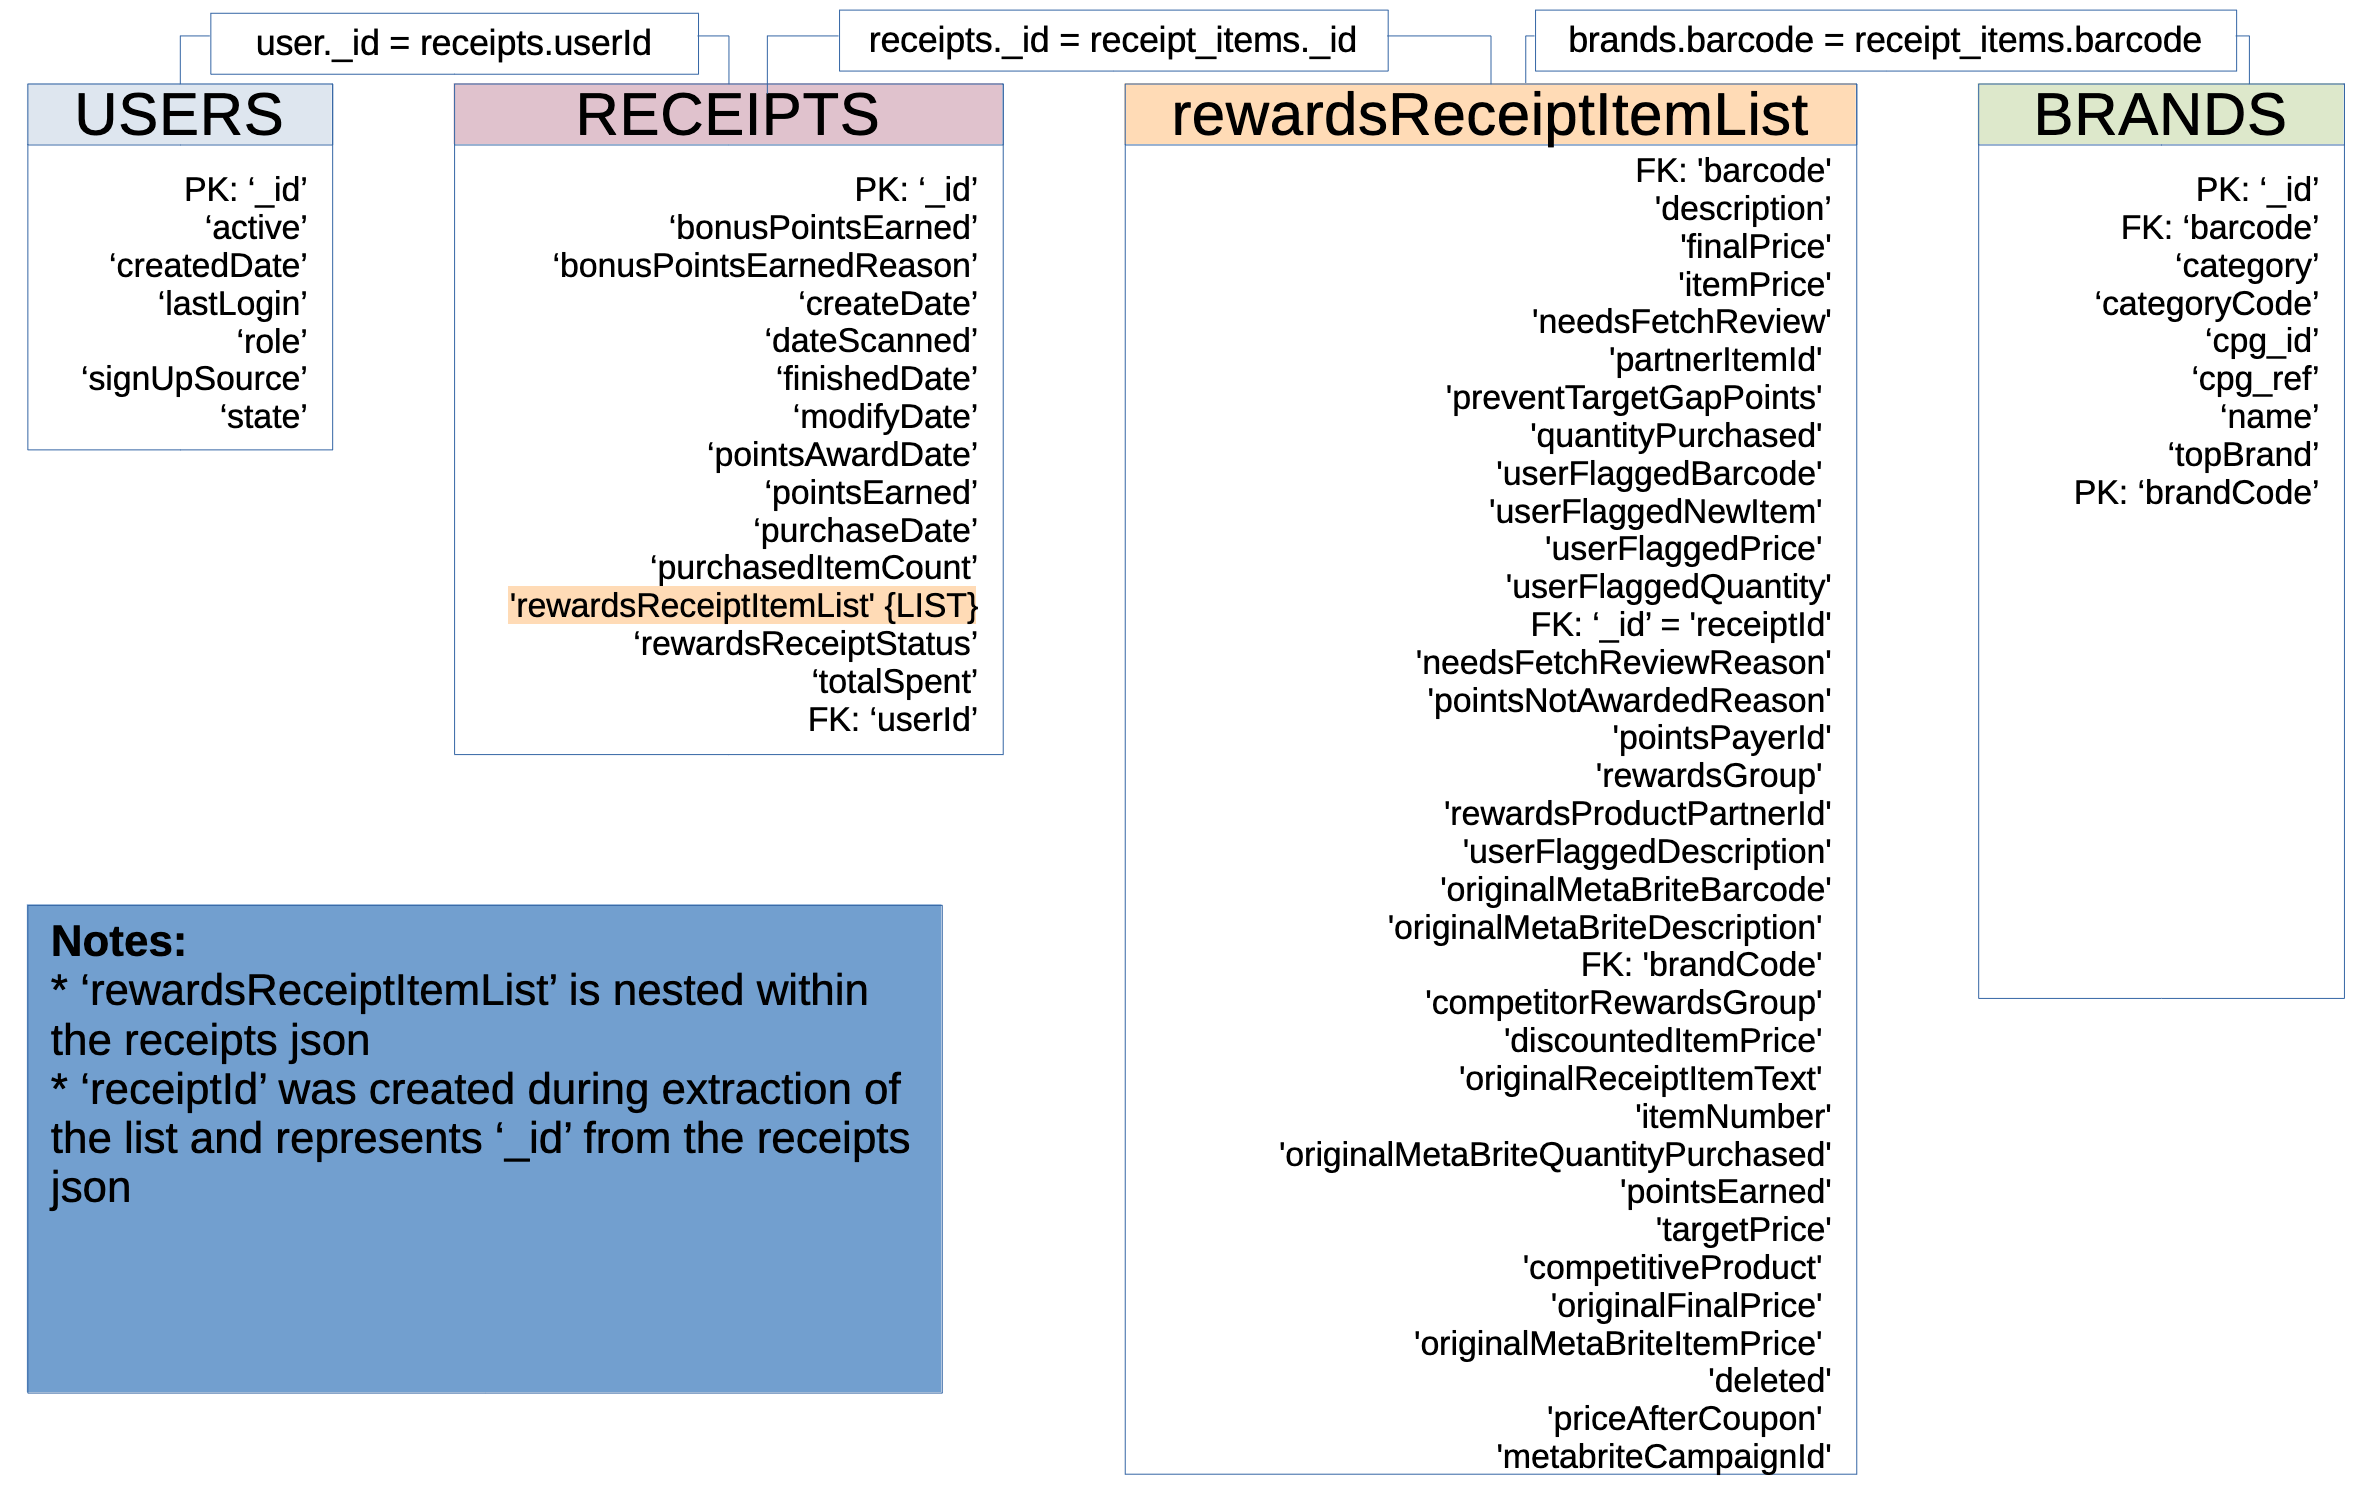

### Part 2: Write queries that directly answer predetermined questions from a business stakeholder

###### Queries to choose from:
1. What are the top 5 brands by receipts scanned for most recent month?
2. How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?
3. When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
4. When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
5. Which brand has the most spend among users who were created within the past 6 months?
6. Which brand has the most transactions among users who were created within the past 6 months?

In [252]:
# Checking the rewardsReceiptStatus that exist in the dataset
query_test = """
SELECT rewardsReceiptStatus, count(*)
FROM receipts
GROUP BY 1;
"""
result_test = pd.read_sql_query(query_test, conn)
print(result_test)

  rewardsReceiptStatus  count(*)
0             FINISHED       518
1              FLAGGED        46
2              PENDING        50
3             REJECTED        71
4            SUBMITTED       434


In [253]:
# Question 3: Accepted vs Rejected average spend
# When considering average spend from receipts with 'rewardsReceiptStatus’ 
# of ‘Accepted’ or ‘Rejected’, which is greater?

# I am assuming that Accepted is considered FINISHED and Rejected is REJECTED
query3 = """
SELECT 
    rewardsReceiptStatus,
    COUNT(*) AS receipt_count,
    AVG(totalSpent) AS avg_spend,
    SUM(totalSpent) AS total_spend
FROM receipts
WHERE rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
    AND totalSpent IS NOT NULL
GROUP BY rewardsReceiptStatus
ORDER BY avg_spend DESC;
"""
result3 = pd.read_sql_query(query3, conn)
print(result3)

# RESULT: Average spend is greater for Accepted receipts.

  rewardsReceiptStatus  receipt_count  avg_spend  total_spend
0             FINISHED            518  80.854305     41882.53
1             REJECTED             71  23.326056      1656.15


In [254]:
# Question 4: Accepted vs Rejected total items
# When considering total number of items purchased from receipts with 
# 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

# I am assuming that Accepted is considered FINISHED and Rejected is REJECTED
query4 = """
SELECT 
    r.rewardsReceiptStatus,
    COUNT(*) AS receipt_count,
    SUM(r.purchasedItemCount) AS total_items_purchased,
    AVG(r.purchasedItemCount) AS avg_items_per_receipt
FROM receipts r
WHERE r.rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
    AND r.purchasedItemCount IS NOT NULL
GROUP BY r.rewardsReceiptStatus
ORDER BY total_items_purchased DESC;
"""
result4 = pd.read_sql_query(query4, conn)
print(result4)

# RESULT: Total number of items purchased is greater for Accepted receipts.

  rewardsReceiptStatus  receipt_count  total_items_purchased  \
0             FINISHED            518                 8184.0   
1             REJECTED             71                  173.0   

   avg_items_per_receipt  
0              15.799228  
1               2.436620  


### Part 3: Evaluate Data Quality Issues in the Data Provided

##### Receipts

In [255]:
# Function to check the nulls across each column
def null_counts(df):
    null_df = pd.DataFrame(df.isnull().sum(),columns=['null_count'])
    null_df['null_fraction'] = null_df['null_count'] / df.shape[0]
    null_df = null_df.sort_values('null_count',ascending=False)
    return null_df

In [256]:
# Setting dataset
# current_df = "receipts_df"
current_df = "receipt_items_df"
# current_df = "brands_df"
# current_df = "users_df"

# Run analysis
df = globals()[current_df]

In [257]:
null_counts(df)

,null_count,null_fraction
originalMetaBriteQuantityPurchased,6926,0.997839
userFlaggedQuantity,6642,0.956923
quantityPurchased,174,0.025068
barcode,0,0.000000
brandCode,0,0.000000
competitorRewardsGroup,0,0.000000
discountedItemPrice,0,0.000000
originalReceiptItemText,0,0.000000
itemNumber,0,0.000000
pointsEarned,0,0.000000


barcode                                  0
description                              0
finalPrice                               0
itemPrice                                0
needsFetchReview                         0
partnerItemId                            0
preventTargetGapPoints                   0
quantityPurchased                      174
userFlaggedBarcode                       0
userFlaggedNewItem                       0
userFlaggedPrice                         0
userFlaggedQuantity                   6642
receiptId                                0
needsFetchReviewReason                   0
pointsNotAwardedReason                   0
pointsPayerId                            0
rewardsGroup                             0
rewardsProductPartnerId                  0
userFlaggedDescription                   0
originalMetaBriteBarcode                 0
originalMetaBriteDescription             0
brandCode                                0
competitorRewardsGroup                   0
discountedI

<Axes: >

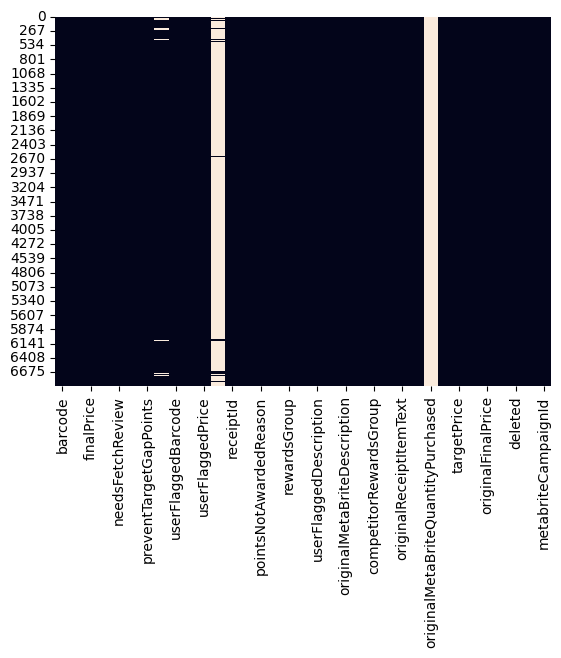

In [258]:
# Check missing values
print(df.isnull().sum())

# Percentage of missing values
print(df.isnull().sum() / len(df) * 100)

# Heatmap missing values
sns.heatmap(df.isnull(), cbar=False)

In [259]:
# Descriptive stats
print(df.describe())

       quantityPurchased  userFlaggedQuantity  \
count        6767.000000           299.000000   
mean            1.386139             1.872910   
std             1.204363             1.314823   
min             1.000000             1.000000   
25%             1.000000             1.000000   
50%             1.000000             1.000000   
75%             1.000000             3.000000   
max            17.000000             5.000000   

       originalMetaBriteQuantityPurchased  
count                           15.000000  
mean                             1.200000  
std                              0.414039  
min                              1.000000  
25%                              1.000000  
50%                              1.000000  
75%                              1.000000  
max                              2.000000  


In [260]:
print(f"Shape: {df.shape}")
print(f"Data types: {df.dtypes}")
print(f"Missing values: {df.isnull().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")

# Unique values
print(f"Unique values per column:")
for col in df.columns:
    print(f"  {col}: {df[col].nunique()}")

Shape: (6941, 35)
Data types: barcode                                object
description                            object
finalPrice                             object
itemPrice                              object
needsFetchReview                       object
partnerItemId                          object
preventTargetGapPoints                 object
quantityPurchased                     float64
userFlaggedBarcode                     object
userFlaggedNewItem                     object
userFlaggedPrice                       object
userFlaggedQuantity                   float64
receiptId                              object
needsFetchReviewReason                 object
pointsNotAwardedReason                 object
pointsPayerId                          object
rewardsGroup                           object
rewardsProductPartnerId                object
userFlaggedDescription                 object
originalMetaBriteBarcode               object
originalMetaBriteDescription           object
bran

###### Data Exploration Technique and Findings: 
###### Technique:
* I used a combination of Python and also viewed the CSVs that I had output since the datasets were small.
* I quickly skimmed the CSVs for issues and also ran each dataset through some basic data exploration. 
* Data exploration was not functionalized, for the most part, to save time. 

###### Findings: 
* Users dataset has a fair amount of duplication. There may be additional rows that were not provided to us that would allow us to select the most up-to-date record. There are also missing values. 
* Brands dataset does not appear to have duplication but it does have some missing values. These missing values are for columns that we would likely not have to use for joining as `_id` and `barcode` both have no missing values. 
* Receipts and Receipt Items datasets are also missing values and Receipt Items is nested inside of Receipts which causes a problem unless it is extracted as its own table. 
* Date formats for the JSONs had to be formatted to corrected show the date and timestamp associated with the event. 
* The other datasets do not have a clear key to tie back to the Brands dataset. I have used `barcode` because it is present in both the Receipt Items table and the Brands table but I am uncertain that it will be a suitable key.
* The Users JSON was a .tar and initially failed ingestion. 
* The majority of the JSON columns were converted to strings for simplicity of the exercise and to allow for exploration of the data.

### Part 4: Communicate with Stakeholders

Hello, 

Thank you for sending over these sample JSONs for us to explore. We ingested your JSON files into our SQL database and explored them in Python to determine if there were any gaps in our understanding of the data. After looking through the data files, our team has some additional questions to better understand the data and task at hand. 

1. In order to ensure that the final output meets your needs, can you provide insight into how the data will be used and what the expected final output will be? This will allow us to create a table that has the necessary dimensions and metrics, while also ensuring that the structure will be adequate.
2. Our team noticed missing values across all of the data files. Should we be ignoring certain records that contain NULLs? In addition, can you help us understand why missing values would exist across these data files?
3. We are assuming that the JSONs sent to us are samples of the actual data that will be ingested. Can you clarify how the actual datasets would reach our team (i.e., via a direct connection in a database, S3, snowpipe, etc.) and what the expected size of each actual dataset will be? Once this information is provided, we can begin determining whether performance and/or scaling issues will be of concern and how we can work to overcome them. 
4. Are there any additional tables that might be useful or necessary for this project?
5. Will any of the unique identifiers change over time in the data files? For example, in the BRANDS data file, will the `barcode` or `_id` for a product ever change over time?

I appreciate your assistance in better understanding these data files and our collaborative project. We want to ensure that we have a solid understanding of the data and the expected deliverable so that we can created as smooth a project as possible and deliver a useful product to you and your team. 

If you have any questions or want to hop on a call to discuss in more detail, please let me know. 

Thank you,

Nick Dysle

In [261]:
# Close SQL connection
conn.close()
print("SQL connection closed")

SQL connection closed
